In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import seaborn as sns

from keras import Model
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam, RMSprop, SGD
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, Input, AveragePooling2D, Activation
from keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import notebook
from os import listdir, path
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
size = (200,200)
dataset_path = 'chest_xray/chest_xray'

In [ ]:
def read_imgs(directory):
    X = []
    y = []
    
    for folder in listdir(directory):
        imgs_path = path.join(directory, folder)

        if folder == 'NORMAL':
            target = 0
        elif folder == 'PNEUMONIA':
            target = 1
        else:
          continue

        print("Processing " + imgs_path + " images")
        for img_path in notebook.tqdm(listdir(imgs_path)):
            if '.jpeg' in img_path:
              img = cv2.imread(path.join(imgs_path, img_path))
              img = cv2.resize(img, size)
              img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
              X.append(img)
              y.append(target)

    X = np.array(X)
    y = np.array(y)
    
    return X, y   

In [ ]:
!unzip 'gdrive/My Drive/chest_xray.zip'

In [ ]:
train_directory = path.join(dataset_path, 'train')
test_directory = path.join(dataset_path, 'test')
val_directory = path.join(dataset_path, 'val')

X_train, y_train = read_imgs(train_directory)
X_test, y_test = read_imgs(test_directory)
X_val, y_val = read_imgs(val_directory)

Processing chest_xray/chest_xray/train/PNEUMONIA images



Processing chest_xray/chest_xray/train/NORMAL images



Processing chest_xray/chest_xray/test/PNEUMONIA images



Processing chest_xray/chest_xray/test/NORMAL images



Processing chest_xray/chest_xray/val/PNEUMONIA images



Processing chest_xray/chest_xray/val/NORMAL images


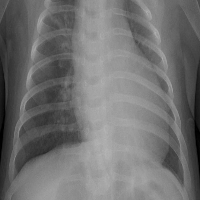

In [ ]:
cv2_imshow(X_train[0])

In [ ]:
# Shuffle data
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)
X_val, y_val = shuffle(X_val, y_val)

In [ ]:
X_train = X_train.reshape((-1, 200, 200, 1))
X_test = X_test.reshape((-1, 200, 200, 1))
X_val = X_val.reshape((-1, 200, 200, 1))

print("X_train shape: ", X_train.shape)
print("X_test shape: ,", X_test.shape)
print("X_val shape: ,", X_val.shape)

X_train shape:  (5216, 200, 200, 1)
X_test shape: , (624, 200, 200, 1)
X_val shape: , (16, 200, 200, 1)


In [ ]:
# Add more images to validation set from training set

X_train, X_val2, y_train, y_val2 = train_test_split(X_train, y_train, test_size=0.12)
X_val = np.append(X_val, X_val2, axis=0)
y_val = np.append(y_val, y_val2, axis=0)
print("X_val shape: ", X_val.shape)


X_val shape:  (642, 200, 200, 1)


{0: 0.25664488017429193, 1: 0.743355119825708}


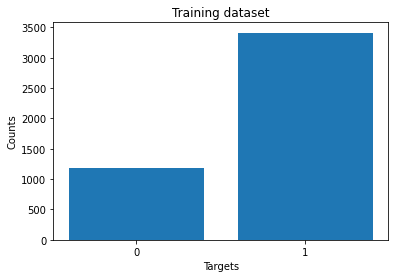

In [ ]:
targets, count = np.unique(y_train, return_counts=True)

class_weight={0:count[0]/X_train.shape[0], 1:count[1]/X_train.shape[0]}
print(class_weight)

plt.title("Training dataset")
plt.bar(targets, count, tick_label=targets)
plt.xlabel("Targets")
plt.ylabel("Counts")
plt.show()

{0: 0.375, 1: 0.625}


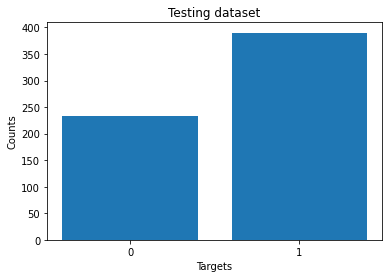

In [ ]:
targets, count = np.unique(y_test, return_counts=True)
print({0:count[0]/X_test.shape[0], 1:count[1]/X_test.shape[0]})

plt.title("Testing dataset")
plt.bar(targets, count, tick_label=targets)
plt.xlabel("Targets")
plt.ylabel("Counts")
plt.show()

{0: 0.26635514018691586, 1: 0.7336448598130841}


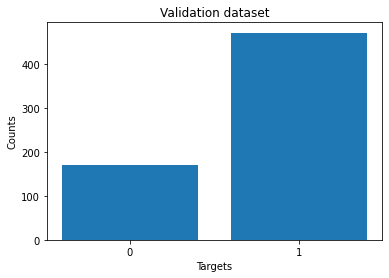

In [ ]:
targets, count = np.unique(y_val, return_counts=True)
print({0:count[0]/X_val.shape[0], 1:count[1]/X_val.shape[0]})

plt.title("Validation dataset")
plt.bar(targets, count, tick_label=targets)
plt.xlabel("Targets")
plt.ylabel("Counts")
plt.show()

In [ ]:
datagen_train = ImageDataGenerator(
  rescale=1./255,
  width_shift_range=0.1,
  height_shift_range=0.1,
  rotation_range=10,  
  zoom_range = 0.1, 
)

datagen_test = ImageDataGenerator(
  rescale=1./255
)

batch_size = 64
train_iterator = datagen_train.flow(X_train, y_train, batch_size=batch_size)
val_iterator = datagen_test.flow(X_val, y_val)

In [ ]:
X_test = X_test/255

In [ ]:
# Function for plotting epoch history
def plot_loss_history(history, title):
    loss = history.history['loss']

    epochs = range(1, len(loss) + 1)

    val_loss = history.history['val_loss']

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [ ]:
"""
MODEL 1 WITH EARLY STOPPING
"""

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(200,200,1)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, kernel_regularizer=regularizers.l1(1e-4), activation='relu'))

model.add(Dropout(0.1))
model.add(Dense(128, kernel_regularizer=regularizers.l1(1e-4), activation='relu'))

model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

history = model.fit(
    train_iterator,
    validation_data=val_iterator, 
    epochs=18, 
    verbose=1, 
    class_weight=class_weight,
    steps_per_epoch=X_train.shape[0] // batch_size,
    validation_steps=X_val.shape[0] // batch_size,  
    callbacks=[es] 
  )

Epoch 1/18
71/71 [==============================] - 16s 213ms/step - loss: 3.5354 - accuracy: 0.7504 - val_loss: 2.6173 - val_accuracy: 0.7656
Epoch 2/18
71/71 [==============================] - 15s 210ms/step - loss: 1.8798 - accuracy: 0.7518 - val_loss: 1.4363 - val_accuracy: 0.7281
Epoch 3/18
71/71 [==============================] - 15s 210ms/step - loss: 0.8609 - accuracy: 0.7523 - val_loss: 0.6516 - val_accuracy: 0.9156
Epoch 4/18
71/71 [==============================] - 15s 210ms/step - loss: 0.4586 - accuracy: 0.8290 - val_loss: 0.5131 - val_accuracy: 0.9250
Epoch 5/18
71/71 [==============================] - 15s 209ms/step - loss: 0.3640 - accuracy: 0.8695 - val_loss: 0.4822 - val_accuracy: 0.9219
Epoch 6/18
71/71 [==============================] - 15s 209ms/step - loss: 0.3221 - accuracy: 0.8766 - val_loss: 0.4180 - val_accuracy: 0.9469
Epoch 7/18
71/71 [==============================] - 15s 211ms/step - loss: 0.2786 - accuracy: 0.8964 - val_loss: 0.3764 - val_accuracy: 0.9344

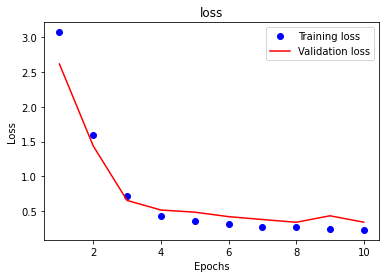

In [ ]:
plot_loss_history(history,"loss")

10/10 [==============================] - 0s 44ms/step - loss: 0.4461 - accuracy: 0.8798
test loss, test acc: [0.44611456990242004, 0.879807710647583]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       201
           1       0.95      0.87      0.91       423

    accuracy                           0.88       624
   macro avg       0.86      0.88      0.87       624
weighted avg       0.89      0.88      0.88       624



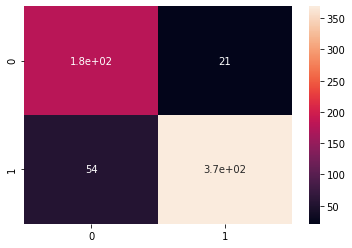

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)
print(classification_report(predictions, y_test))
cm = confusion_matrix(predictions, y_test)
sns.heatmap(cm, annot=True)

Epoch 1/20
71/71 [==============================] - 16s 214ms/step - loss: 0.9875 - accuracy: 0.7373 - val_loss: 1.2492 - val_accuracy: 0.7188
Epoch 2/20
71/71 [==============================] - 15s 211ms/step - loss: 0.8412 - accuracy: 0.7423 - val_loss: 1.1786 - val_accuracy: 0.7000
Epoch 3/20
71/71 [==============================] - 15s 211ms/step - loss: 0.7533 - accuracy: 0.7383 - val_loss: 0.9274 - val_accuracy: 0.8969
Epoch 4/20
71/71 [==============================] - 15s 211ms/step - loss: 0.6508 - accuracy: 0.7903 - val_loss: 0.8435 - val_accuracy: 0.8844
Epoch 5/20
71/71 [==============================] - 15s 210ms/step - loss: 0.5816 - accuracy: 0.8169 - val_loss: 0.7574 - val_accuracy: 0.9281
Epoch 6/20
71/71 [==============================] - 15s 211ms/step - loss: 0.5212 - accuracy: 0.8474 - val_loss: 0.7290 - val_accuracy: 0.9000
Epoch 7/20
71/71 [==============================] - 15s 212ms/step - loss: 0.4576 - accuracy: 0.8750 - val_loss: 0.7228 - val_accuracy: 0.7937

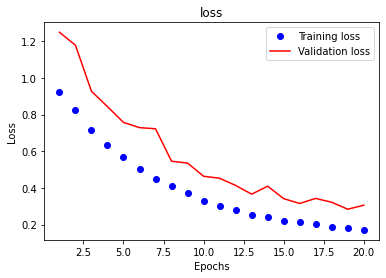

In [ ]:
"""
MODEL 2 WITH 20 EPOCHS
"""

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(200,200,1)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, kernel_regularizer=regularizers.l1(1e-4), activation='relu'))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, kernel_regularizer=regularizers.l1(1e-4), activation='relu'))

model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)


model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_iterator,
    validation_data=val_iterator, 
    epochs=20, 
    verbose=1, 
    class_weight=class_weight,
    steps_per_epoch=X_train.shape[0] // batch_size,
    validation_steps=X_val.shape[0] // batch_size,  
  )
plot_loss_history(history,"loss")

10/10 [==============================] - 1s 44ms/step - loss: 0.4672 - accuracy: 0.8462
test loss, test acc: [0.4671759009361267, 0.8461538553237915]
              precision    recall  f1-score   support

           0       0.61      0.97      0.75       146
           1       0.99      0.81      0.89       478

    accuracy                           0.85       624
   macro avg       0.80      0.89      0.82       624
weighted avg       0.90      0.85      0.86       624



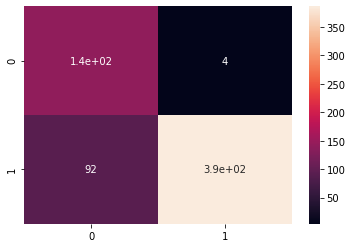

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)
print(classification_report(predictions, y_test))
cm = confusion_matrix(predictions, y_test)
sns.heatmap(cm, annot=True)

Epoch 1/45
71/71 [==============================] - 15s 207ms/step - loss: 0.9835 - accuracy: 0.7235 - val_loss: 1.2050 - val_accuracy: 0.7563
Epoch 2/45
71/71 [==============================] - 15s 206ms/step - loss: 0.8424 - accuracy: 0.7486 - val_loss: 1.1901 - val_accuracy: 0.7094
Epoch 3/45
71/71 [==============================] - 15s 207ms/step - loss: 0.7827 - accuracy: 0.7429 - val_loss: 1.0657 - val_accuracy: 0.7406
Epoch 4/45
71/71 [==============================] - 15s 207ms/step - loss: 0.6928 - accuracy: 0.7528 - val_loss: 0.8756 - val_accuracy: 0.8531
Epoch 5/45
71/71 [==============================] - 15s 207ms/step - loss: 0.6021 - accuracy: 0.8090 - val_loss: 0.7345 - val_accuracy: 0.8906
Epoch 6/45
71/71 [==============================] - 15s 206ms/step - loss: 0.5215 - accuracy: 0.8572 - val_loss: 0.7707 - val_accuracy: 0.8438
Epoch 7/45
71/71 [==============================] - 15s 208ms/step - loss: 0.4819 - accuracy: 0.8651 - val_loss: 0.6006 - val_accuracy: 0.9281

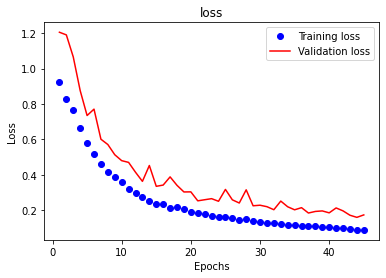

10/10 [==============================] - 1s 42ms/step - loss: 0.3969 - accuracy: 0.8478
test loss, test acc: [0.39689695835113525, 0.8477563858032227]
              precision    recall  f1-score   support

           0       0.61      0.97      0.75       147
           1       0.99      0.81      0.89       477

    accuracy                           0.85       624
   macro avg       0.80      0.89      0.82       624
weighted avg       0.90      0.85      0.86       624



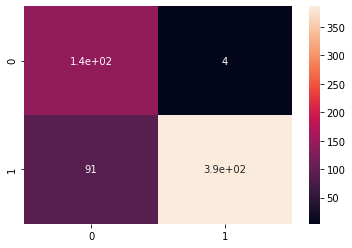

In [ ]:
"""
MODEL 2 TRAINING FOR 45 EPOCHS
"""

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(200,200,1)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, kernel_regularizer=regularizers.l1(1e-4), activation='relu'))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, kernel_regularizer=regularizers.l1(1e-4), activation='relu'))

model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)


model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0000001, verbose=1)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

history = model.fit(
    train_iterator,
    validation_data=val_iterator, 
    epochs=45, 
    verbose=1, 
    class_weight=class_weight,
    steps_per_epoch=X_train.shape[0] // batch_size,
    validation_steps=X_val.shape[0] // batch_size,  
  )
plot_loss_history(history,"loss")

results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)
print(classification_report(predictions, y_test))
cm = confusion_matrix(predictions, y_test)
sns.heatmap(cm, annot=True)

Epoch 1/45
71/71 [==============================] - 15s 208ms/step - loss: 3.5308 - accuracy: 0.7304 - val_loss: 2.5974 - val_accuracy: 0.7594
Epoch 2/45
71/71 [==============================] - 15s 207ms/step - loss: 1.8780 - accuracy: 0.7462 - val_loss: 1.3001 - val_accuracy: 0.7250
Epoch 3/45
71/71 [==============================] - 15s 207ms/step - loss: 0.8768 - accuracy: 0.7584 - val_loss: 0.7217 - val_accuracy: 0.8750
Epoch 4/45
71/71 [==============================] - 15s 207ms/step - loss: 0.4886 - accuracy: 0.8369 - val_loss: 0.5267 - val_accuracy: 0.9469
Epoch 5/45
71/71 [==============================] - 15s 207ms/step - loss: 0.4002 - accuracy: 0.8606 - val_loss: 0.5065 - val_accuracy: 0.9156
Epoch 6/45
71/71 [==============================] - 15s 207ms/step - loss: 0.3521 - accuracy: 0.8651 - val_loss: 0.4269 - val_accuracy: 0.9406
Epoch 7/45
71/71 [==============================] - 15s 208ms/step - loss: 0.3113 - accuracy: 0.8937 - val_loss: 0.4023 - val_accuracy: 0.9594

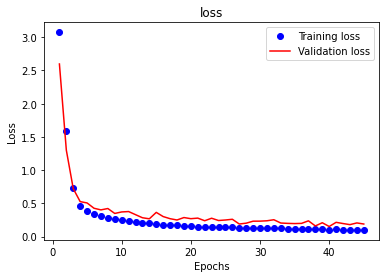

10/10 [==============================] - 1s 41ms/step - loss: 0.3577 - accuracy: 0.8798
test loss, test acc: [0.35767677426338196, 0.879807710647583]
              precision    recall  f1-score   support

           0       0.71      0.95      0.82       175
           1       0.98      0.85      0.91       449

    accuracy                           0.88       624
   macro avg       0.85      0.90      0.86       624
weighted avg       0.90      0.88      0.88       624



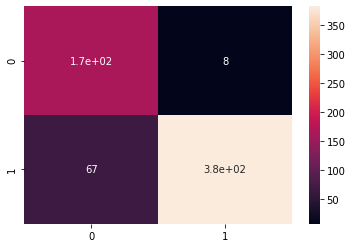

In [ ]:
"""
MODEL 1 WITH 45 EPOCHS
"""
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(200,200,1)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, kernel_regularizer=regularizers.l1(1e-4), activation='relu'))

model.add(Dropout(0.1))
model.add(Dense(128, kernel_regularizer=regularizers.l1(1e-4), activation='relu'))

model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(
    train_iterator,
    validation_data=val_iterator, 
    epochs=45, 
    verbose=1, 
    class_weight=class_weight,
    steps_per_epoch=X_train.shape[0] // batch_size,
    validation_steps=X_val.shape[0] // batch_size,  
  )

plot_loss_history(history,"loss")

results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)
print(classification_report(predictions, y_test))
cm = confusion_matrix(predictions, y_test)
sns.heatmap(cm, annot=True)